In [2]:
import scipy
import json
import os
import numpy as np

import pandas as pd
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.stattools import ccf

# Part 1: Common Functions

In [3]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str,
):
    """
    Load attack result files and combine them into a single pandas DataFrame.

    This function reads:
    - A JSON file containing attack results.
    - CSV files containing Shapley values and Leave-One-Out (LOO) scores.

    It merges these results into a single pandas DataFrame for further analysis.

    Args:
        scenario (str): The name of the attack scenario.
        version (str): The version identifier of the attack.
        dataset (str): The name of the dataset used.

    Returns:
        pandas.DataFrame: A DataFrame containing the combined attack results, Shapley values, and LOO scores.
    """
        
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
    
    return dataframe

In [4]:
def load_single_contribution_attack_results(
    scenario: str,
    version: str,
    dataset: str
):
    """
    Load attack result files and combine them into a single pandas DataFrame.

    This function reads:
    - A JSON file containing attack results.
    - CSV files containing Shapley values and Leave-One-Out (LOO) scores.

    It merges these results into a single pandas DataFrame for further analysis.

    Args:
        scenario (str): The name of the attack scenario.
        version (str): The version identifier of the attack.
        dataset (str): The name of the dataset used.

    Returns:
        pandas.DataFrame: A DataFrame containing the combined attack results, Shapley values, and LOO scores.
    """
    
    ## Loads the json file with atack metrics
    metrics = ['TPR', 'AUC']
    json_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'nodes_attack_results.json')
    shapley_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_shapley.csv')
    loo_path = os.path.join(os.getcwd(), 'attack_results', scenario, version, dataset, 'results', 'partial_loo.csv')
    with open(json_path, 'r+') as file:
        json_file = json.load(file)
    clients_ids = [int(i) for i in json_file.keys() if i != 'average']
    iterations = [int(i) for i in json_file['0'].keys()]
    iterations.sort()
    headings = [f'{client}_{metric}' for client in clients_ids for metric in metrics]
    
    dataframe = pd.DataFrame(index=iterations, columns=headings)
    
    # Loads attack results into the frame
    for client in clients_ids:
        for iteration in iterations:
            client_data = json_file[str(client)][str(iteration)]['average']
            for heading in metrics:
                dataframe.loc[iteration, f"{client}_{heading}"] = client_data[heading]
    
    # Loads shapley into the frame
    shapley_frame = pd.read_csv(shapley_path)
    loo_frame = pd.read_csv(loo_path)
    for client in clients_ids:
        # Loads shapley values
        array = shapley_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_ACC'] = array
        array = shapley_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_SHAP_F1SCORE'] = array
        
        # Loads LOO values
        array = loo_frame[shapley_frame['node_id'] == client]['accuracy'].reset_index(drop=True)
        dataframe[f'{client}_LOO_ACC'] = array
        array = loo_frame[shapley_frame['node_id'] == client]['f1score'].reset_index(drop=True)
        dataframe[f'{client}_LOO_F1SCORE'] = array
    
    return dataframe

In [5]:
def load_multiple_contribution_attack_results(
    scenarios: list[str],
    versions: list[str],
    datasets: list[str]
):
    """
    Load multiple sets of attack result files and return them as a dictionary of pandas DataFrames.

    For each provided scenario, version, and dataset:
    - Reads a JSON file containing attack results.
    - Reads CSV files containing Shapley values and Leave-One-Out (LOO) scores.
    - Combines them into a single pandas DataFrame.

    All DataFrames are returned in a dictionary, keyed by (scenario, version, dataset).

    Args:
        scenarios (list[str]): A list of attack scenario types.
        versions (list[str]): A list of version identifiers.
        datasets (list[str]): A list of dataset names.

    Returns:
        dict[tuple[str, str, str], pandas.DataFrame]: 
            A dictionary where each key is a (scenario, version, dataset) tuple 
            and each value is the corresponding combined DataFrame of attack results.
    """
    all_results = {
        f"{scenario}_{version}_{dataset}" : None
        for scenario in scenarios
        for version in versions
        for dataset in datasets
    }
    for scenario in scenarios:
        for version in versions:
            for dataset in datasets:
                key = f"{scenario}_{version}_{dataset}"
                all_results[key] = load_single_contribution_attack_results(
                    scenario=scenario,
                    version=version,
                    dataset=dataset
                    )
    return all_results

In [6]:
def calculate_single_corr(
    no_clients: int,
    frame: pd.DataFrame,
    mode: str,
):
    """
    Calculate correlation metrics from a single attack results DataFrame.

    Based on the selected mode, this function computes correlation statistics 
    (e.g., Pearson, Spearman) between client-specific values in the provided DataFrame.

    Args:
        no_clients (int): The number of clients involved in the attack scenario.
        frame (pd.DataFrame): The DataFrame containing attack results, Shapley values, and LOO scores.
        mode (str): The type of correlation to compute (e.g., 'pearson', 'spearman').

    Returns:
        pd.DataFrame: A DataFrame containing the computed correlation values.
    """
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).statistic
        
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).statistic
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).statistic
    return corr_frame

In [7]:
def calculate_single_stationarity(
    no_clients: int,
    frame: pd.DataFrame,
    shap_mode: str
):
    """
    Calculate stationarity metrics from a single attack results DataFrame.

    This function evaluates how stable (stationary) the Shapley values or LOO scores 
    are across clients, based on the selected scoring mode ("ACC" for accuracy or "F1SCORE" for F1 score).

    Args:
        no_clients (int): The number of clients involved in the attack scenario.
        frame (pd.DataFrame): The DataFrame containing attack results, Shapley values, and LOO scores.
        shap_mode (str): The scoring metric to use for stationarity computation. Must be either "ACC" or "F1SCORE".

    Returns:
        pd.DataFrame: A DataFrame containing the computed stationarity metrics.
    """
    assert shap_mode == 'ACC' or shap_mode == 'F1SCORE'
    statio_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        tpr_results = sm.tsa.stattools.adfuller(frame[f'{client}_TPR'])
        shap_results = sm.tsa.stattools.adfuller(frame[f'{client}_SHAP_{shap_mode}'])
        
        statio_frame.loc[client, 'TPR ADF Statistic'] = tpr_results[0]
        statio_frame.loc[client, 'TPR ADF p-value'] = tpr_results[1]
        statio_frame.loc[client, 'SHAP ADF Statistic'] = shap_results[0]
        statio_frame.loc[client, 'SHAP ADF p-value'] = shap_results[1]

    return statio_frame

In [8]:
def calculate_single_corr_short(
    no_clients: int,
    frame: pd.DataFrame,
    mode: str,
):
    """
    Calculate correlation metrics between TPR and Shapley-based scores for each client.

    This function computes either Spearman or Pearson correlation between:
    - True Positive Rate (TPR) and Shapley Accuracy (SHAP_ACC)
    - True Positive Rate (TPR) and Shapley F1 Score (SHAP_F1SCORE)

    for each client individually.

    Args:
        no_clients (int): The number of clients involved in the attack scenario.
        frame (pd.DataFrame): The DataFrame containing client-specific TPR, SHAP_ACC, and SHAP_F1SCORE columns.
        mode (str): The type of correlation to compute. Must be either "spearman" or "pearson".

    Returns:
        pd.DataFrame: A DataFrame where each row corresponds to a client, containing:
            - TPR to SHAP_ACC correlation coefficient and p-value
            - TPR to SHAP_F1SCORE correlation coefficient and p-value

    Raises:
        NameError: If the provided `mode` is not "spearman" or "pearson".
    """
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        )
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = corr.statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC P-VALUE'] = corr.pvalue
        
        corr = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        )
        
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = corr.statistic
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE P-VALUE'] = corr.pvalue
        
    return corr_frame

In [9]:
def calculate_single_crosscor(
    no_clients: int,
    no_round: int,
    frame: pd.DataFrame,
    shift: int,
    shap_mode: str
):
    """
    Calculate cross-correlation between TPR and Shapley-based scores across communication rounds.

    This function computes the cross-correlation between the True Positive Rate (TPR) and Shapley values
    (based on either "ACC" or "F1SCORE") for each client, applying a specified time shift across rounds.

    Args:
        no_clients (int): The number of clients involved in the attack scenario.
        no_round (int): The total number of communication rounds or evaluation rounds.
        frame (pd.DataFrame): The DataFrame containing TPR and Shapley score values for each client and round.
        shift (int): The amount of shift (positive or negative) to apply when computing cross-correlation.
        shap_mode (str): The Shapley score type to use. Must be either "ACC" (accuracy-based) or "F1SCORE" (F1 score-based).

    Returns:
        pd.DataFrame: A DataFrame containing the cross-correlation results for each client.

    Raises:
        ValueError: If `shap_mode` is not "ACC" or "F1SCORE".
    """
    crosscorr_frame = pd.DataFrame(index=range(no_round * 2 - 1), columns=[f"client_{client}" for client in range(no_clients)])
    
    for client in range(no_clients):
        series_X = frame[f'{client}_TPR']
        series_Y = np.roll(frame[f'{client}_SHAP_{shap_mode}'], shift=shift)
        crosscorr_frame[f"client_{client}"] = np.array(correlate(series_X - np.mean(series_X), series_Y - np.mean(series_Y), mode="full"))
    
    return crosscorr_frame

In [10]:
def calculate_multiple_stationarity(
    results : dict,
    no_clients : int,
    shap_mode : str
):
    """
    Calculate stationarity metrics across multiple attack result DataFrames.

    This function computes stationarity statistics (stability of Shapley values or LOO scores) 
    for each DataFrame stored in the provided dictionary of results, based on the selected Shapley scoring mode.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        shap_mode (str): The Shapley score type to use for stationarity computation. 
                         Must be either "ACC" (accuracy-based) or "F1SCORE" (F1 score-based).

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing the stationarity metrics for that specific attack result.

    Raises:
        ValueError: If `shap_mode` is not "ACC" or "F1SCORE".
    """
    assert shap_mode == 'ACC' or shap_mode == 'F1SCORE'
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_stationarity(frame=frame, no_clients=no_clients, shap_mode=shap_mode)
    return all_results

In [11]:
def calculate_multiple_corr(
    results : dict,
    no_clients : int,
    mode : str
):
    """
    Calculate correlation metrics across multiple attack result DataFrames.

    For each entry in the results dictionary, this function computes either Pearson or Spearman
    correlation between True Positive Rate (TPR) and Shapley-based scores (Accuracy or F1 Score)
    for each client.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        mode (str): The type of correlation to compute. Must be either "pearson" or "spearman".

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing the correlation metrics for that specific attack result.

    Raises:
        ValueError: If `mode` is not "pearson" or "spearman".
    """
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [12]:
def calculate_multiple_corr_short(
    results : dict,
    no_clients : int,
    mode : str
):
    """
    Calculate simplified correlation metrics across multiple attack result DataFrames.

    For each entry in the results dictionary, this function computes either Pearson or Spearman 
    correlation between True Positive Rate (TPR) and Shapley-based scores (both Accuracy and F1 Score) 
    for each client, and returns only the key correlation statistics and p-values.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        mode (str): The type of correlation to compute. Must be either "pearson" or "spearman".

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing simplified correlation metrics (coefficients and p-values) for each client.

    Raises:
        ValueError: If `mode` is not "pearson" or "spearman".
    """
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr_short(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [13]:
def calculate_multiple_stat(
    results : dict,
    no_clients : int,
    mode : str
):
    """
    Calculate statistical metrics across multiple attack result DataFrames.

    For each entry in the results dictionary, this function computes summary statistics
    based on the selected mode for each client individually.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        mode (str): The type of statistic to compute. Must match a supported statistical operation.

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing the computed statistics for each client.

    Raises:
        ValueError: If `mode` is not a supported statistic type.
    """
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_corr(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

In [14]:
def calculate_multiple_crosscorr(
    results : dict,
    no_clients : int,
    no_round : int,
    shift : int,
    shap_mode : str
):
    """
    Calculate cross-correlation metrics across multiple attack result DataFrames.

    For each entry in the results dictionary, this function computes the cross-correlation 
    between True Positive Rate (TPR) and Shapley-based scores (Accuracy or F1 Score) 
    across communication rounds, applying a specified time shift.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        no_round (int): The number of communication rounds or evaluation steps.
        shift (int): The number of rounds to shift when computing cross-correlation.
        shap_mode (str): The Shapley score type to use. Must be either "ACC" (accuracy-based) or "F1SCORE" (F1 score-based).

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing cross-correlation results for each client.

    Raises:
        ValueError: If `shap_mode` is not "ACC" or "F1SCORE".
    """
    assert shap_mode == 'ACC' or shap_mode == 'F1SCORE'
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_crosscor(frame=frame, no_clients=no_clients, no_round=no_round, shift=shift, shap_mode=shap_mode)
    return all_results

In [15]:
def calculate_single_pvalue(
    no_clients: int,
    frame: pd.DataFrame,
    mode: 'str'
):
    """
    Calculate p-values for correlation metrics from a single attack results DataFrame.

    For each client, this function computes the p-value associated with the correlation 
    between True Positive Rate (TPR) and Shapley-based scores, using the specified correlation mode.

    Args:
        no_clients (int): The number of clients involved in the attack scenario.
        frame (pd.DataFrame): The DataFrame containing attack results, including TPR and Shapley scores.
        mode (str): The correlation method to use. Must be either "pearson" or "spearman".

    Returns:
        pd.DataFrame: A DataFrame containing p-values for each client's correlation results.

    Raises:
        ValueError: If `mode` is not "pearson" or "spearman".
    """
    if mode == 'spearman':
        correlation = scipy.stats.spearmanr
    elif mode =='pearson':
        correlation = scipy.stats.pearsonr
    else:
        assert NameError
    corr_frame = pd.DataFrame(index=range(no_clients))
    
    for client in range(no_clients):
        corr_frame.loc[client, 'TPR_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_SHAP_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_SHAP_F1SCORE']
        ).pvalue
        
        corr_frame.loc[client, 'TPR_TO_LOO_ACC'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_ACC'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_ACC']
        ).pvalue
        corr_frame.loc[client, 'TPR_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_TPR'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
        corr_frame.loc[client, 'AUC_TO_LOO_F1SCORE'] = correlation(
            frame[f'{client}_AUC'],
            frame[f'{client}_LOO_F1SCORE']
        ).pvalue
    return corr_frame

In [16]:
def calculate_multiple_pvalues(
    results : dict,
    no_clients : int,
    mode : str
):
    """
    Calculate p-values for correlation metrics across multiple attack result DataFrames.

    For each entry in the results dictionary, this function computes the p-values 
    associated with the correlation between True Positive Rate (TPR) and Shapley-based scores 
    for each client, using the specified correlation mode.

    Args:
        results (dict): A dictionary where keys are (scenario, version, dataset) identifiers and 
                        values are pandas DataFrames containing attack results.
        no_clients (int): The number of clients involved in each attack scenario.
        mode (str): The correlation method to use. Must be either "pearson" or "spearman".

    Returns:
        dict: A dictionary mapping each (scenario, version, dataset) key to a pandas DataFrame 
              containing the p-values for each client's correlation results.

    Raises:
        ValueError: If `mode` is not "pearson" or "spearman".
    """
    all_results = {key:None for key in results.keys()}
    for key, frame in results.items():
        all_results[key] = calculate_single_pvalue(frame=frame, no_clients=no_clients, mode=mode)
    return all_results

# Part 2: Inspection based on ACC-SHAP

## Part 2.1: Visual Inspection

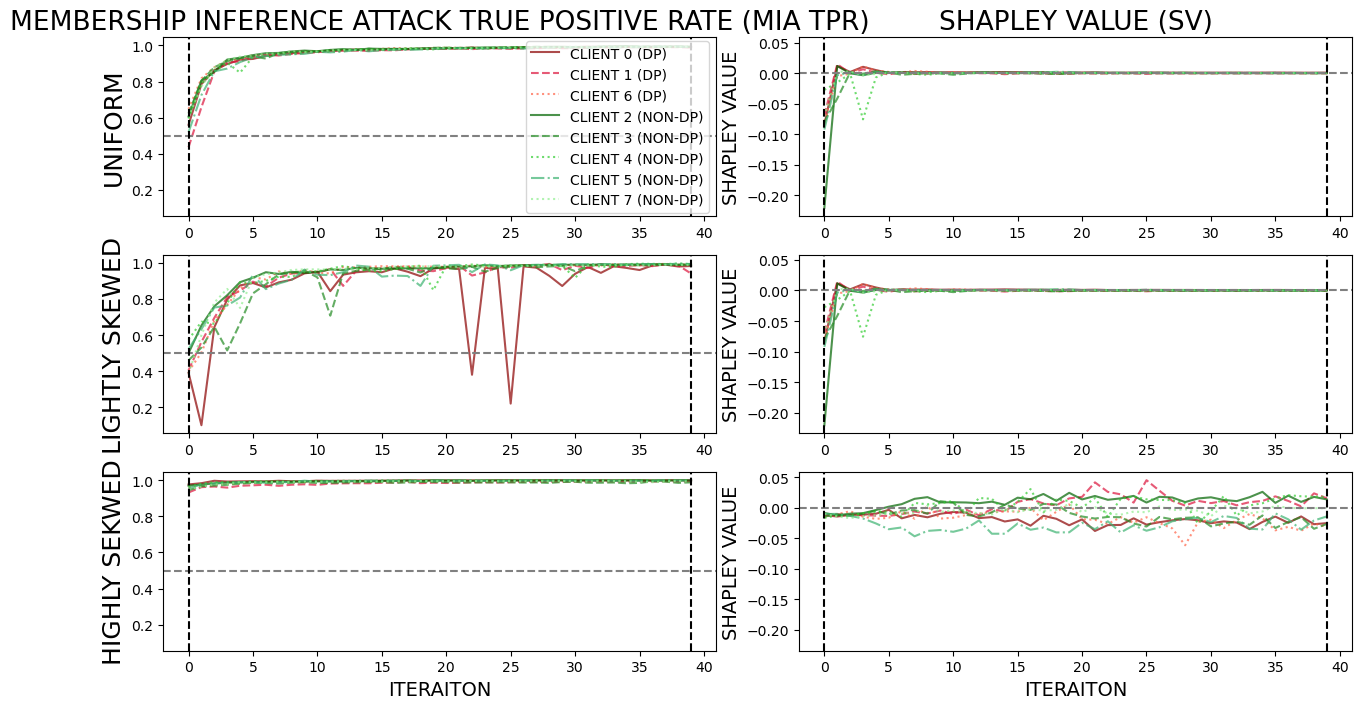

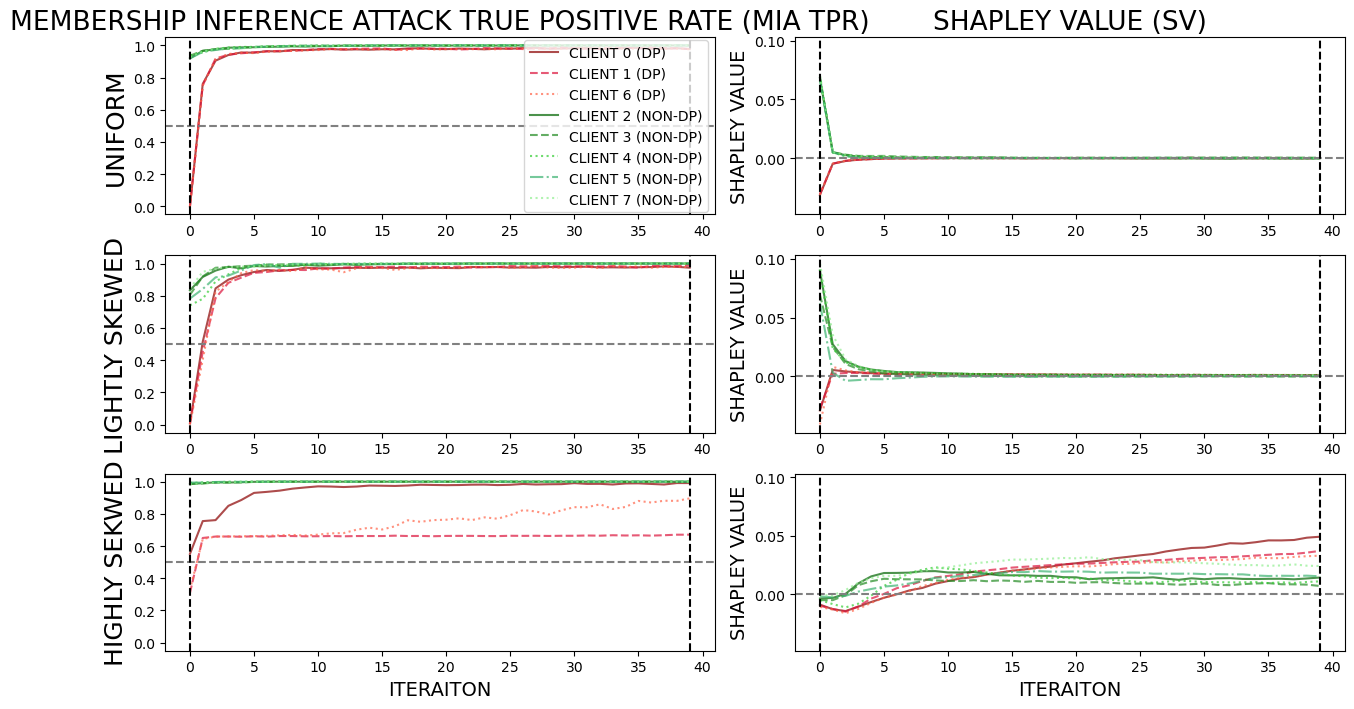

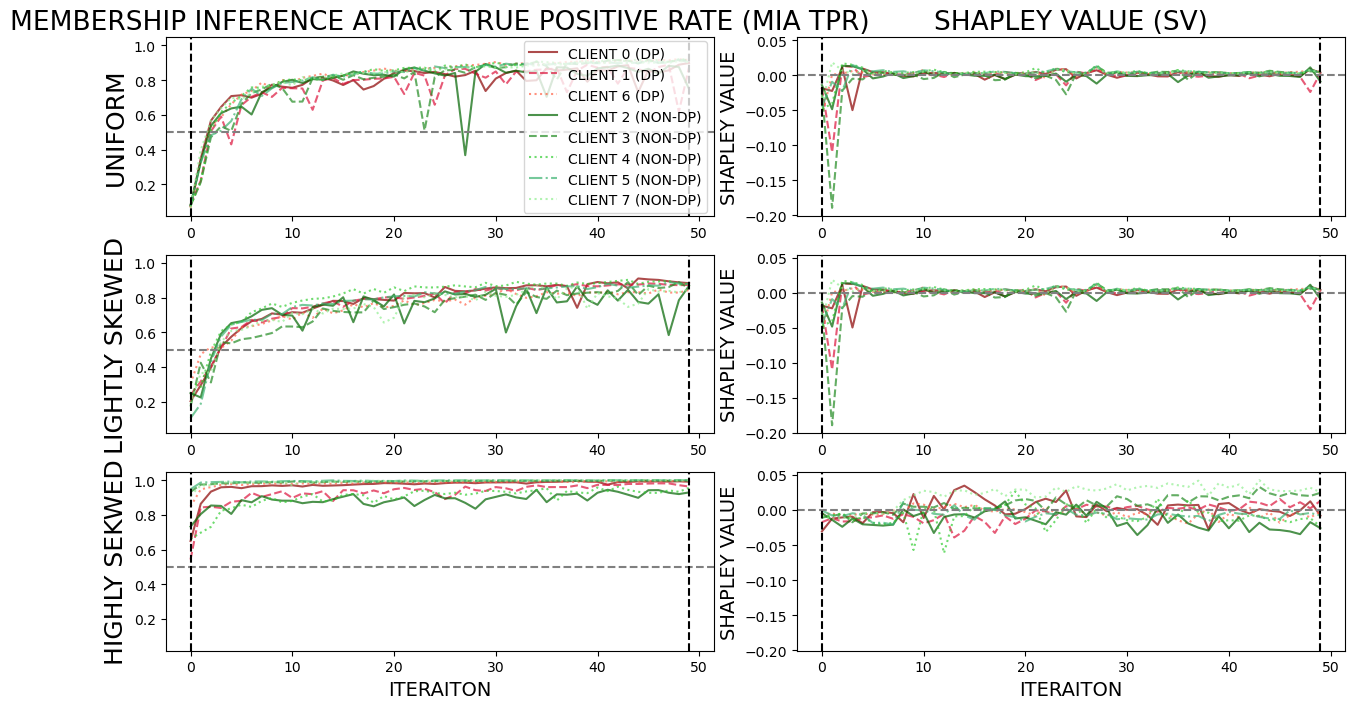

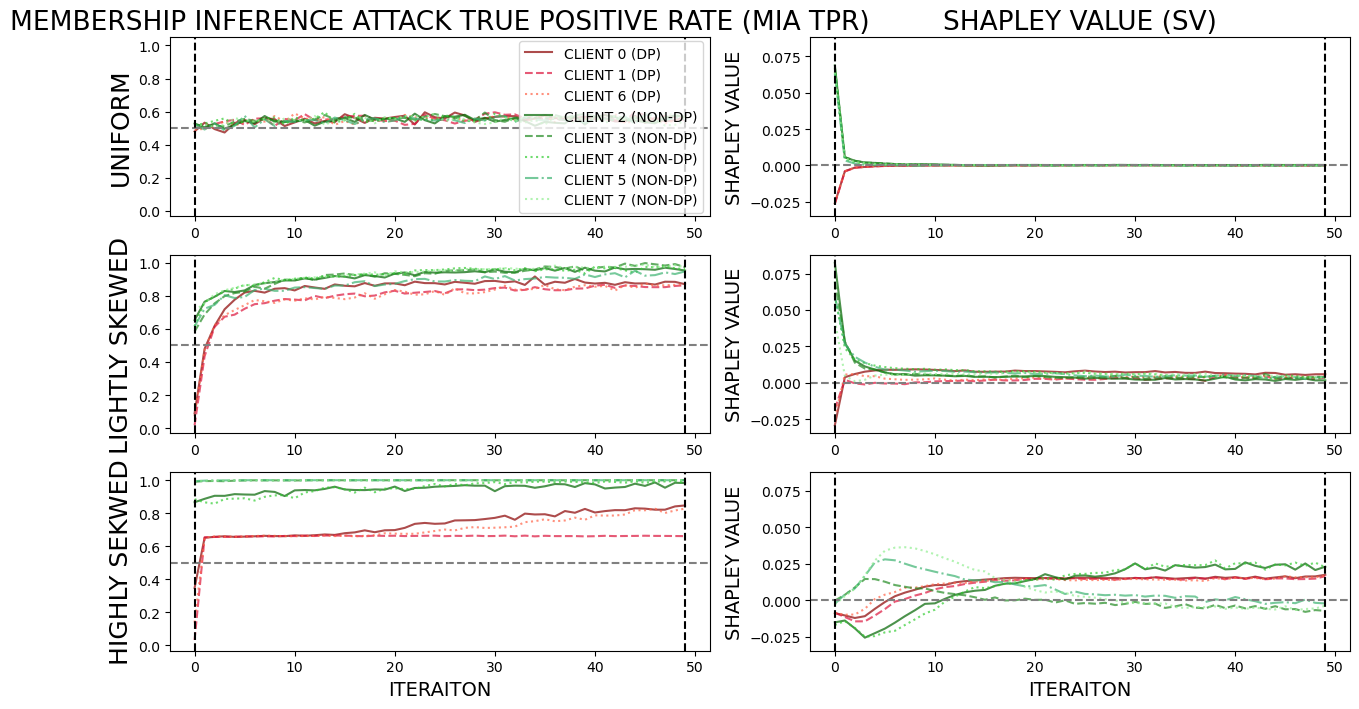

In [17]:
datasets = ['mnist', 'fmnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    1: ('#DC143C', '--'),  # Crimson Red (Dashed)
    6: ('#FF6347', ':'),   # Tomato Red (Dotted)
    2: ('#006400', '-'),   # Dark Green (Solid)
    3: ('#228B22', '--'),  # Forest Green (Dashed)
    4: ('#32CD32', ':'),   # Lime Green (Dotted)
    5: ('#3CB371', '-.'),  # Medium Sea Green (Dash-Dot)
    7: ('#90EE90', ':')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=(12.8, 7.2))
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 1, 6]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [2, 3, 4, 5, 7]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MEMBERSHIP INFERENCE ATTACK TRUE POSITIVE RATE (MIA TPR)", fontsize=19)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=19)

        axes[0,0].set_ylabel('UNIFORM', fontsize=18)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=18)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=18)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        if dataset == 'mnist':
            x = 39
        else:
            x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=14)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=14)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        fig.tight_layout()

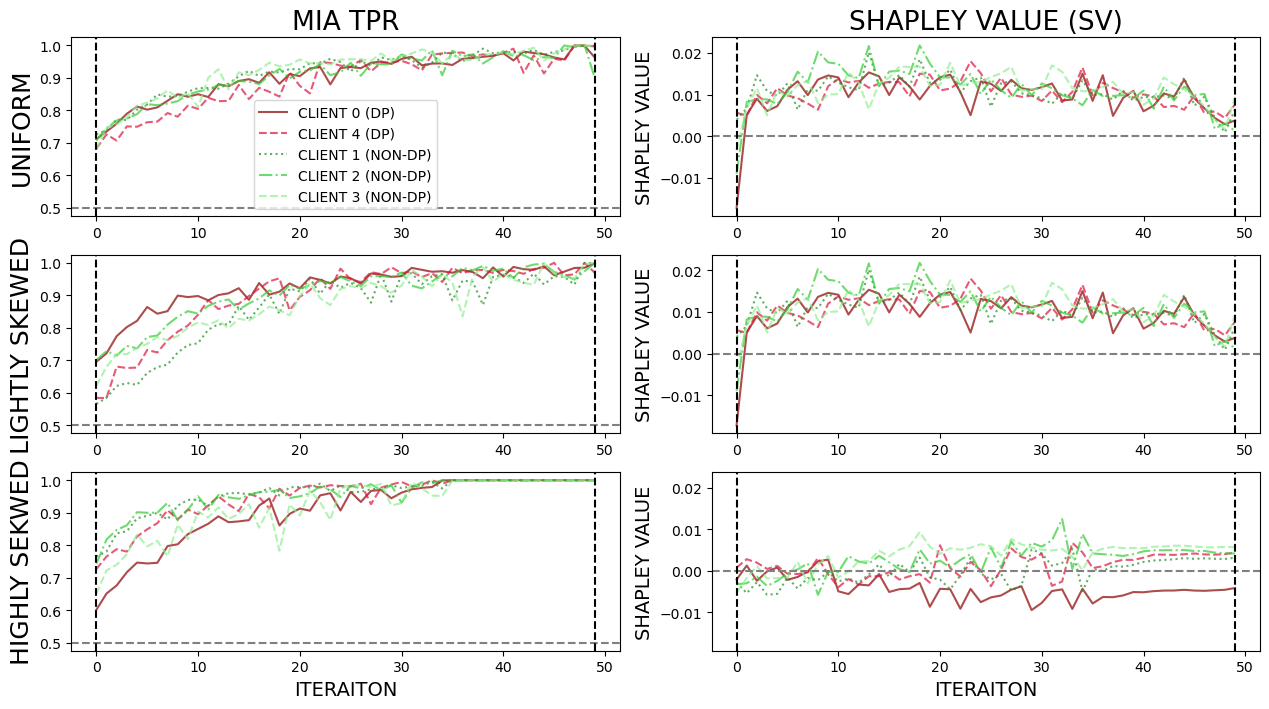

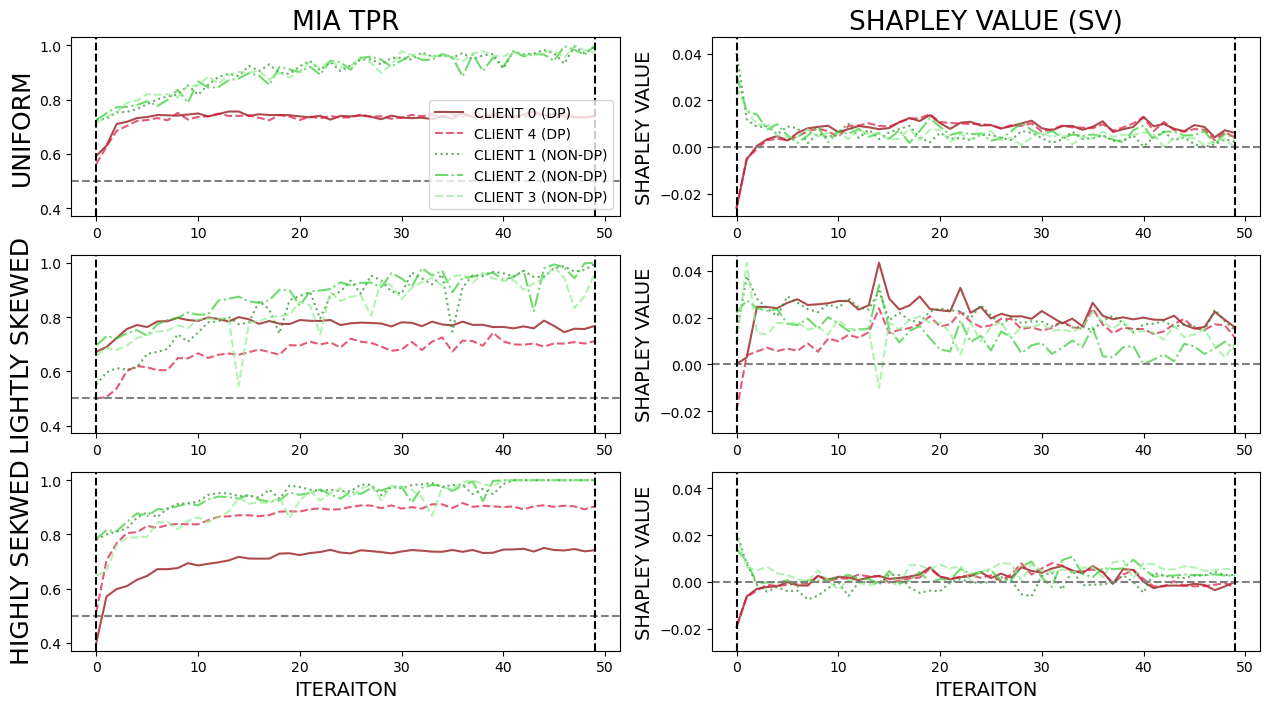

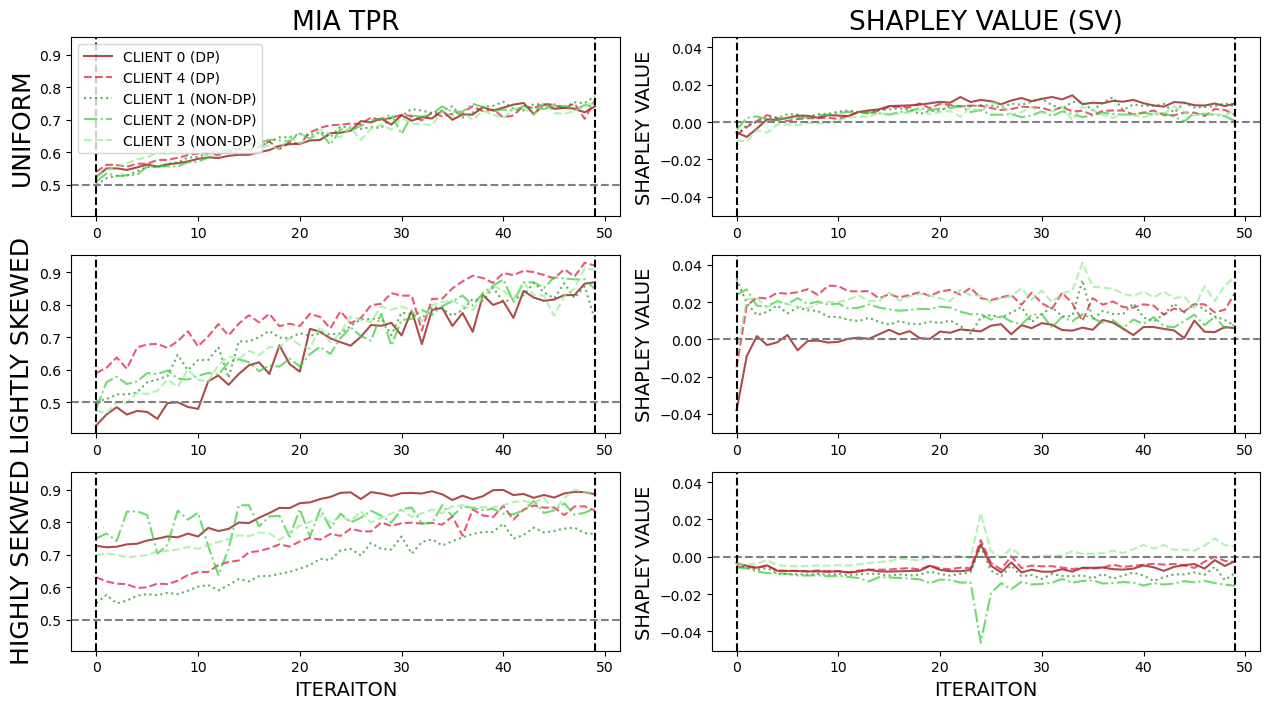

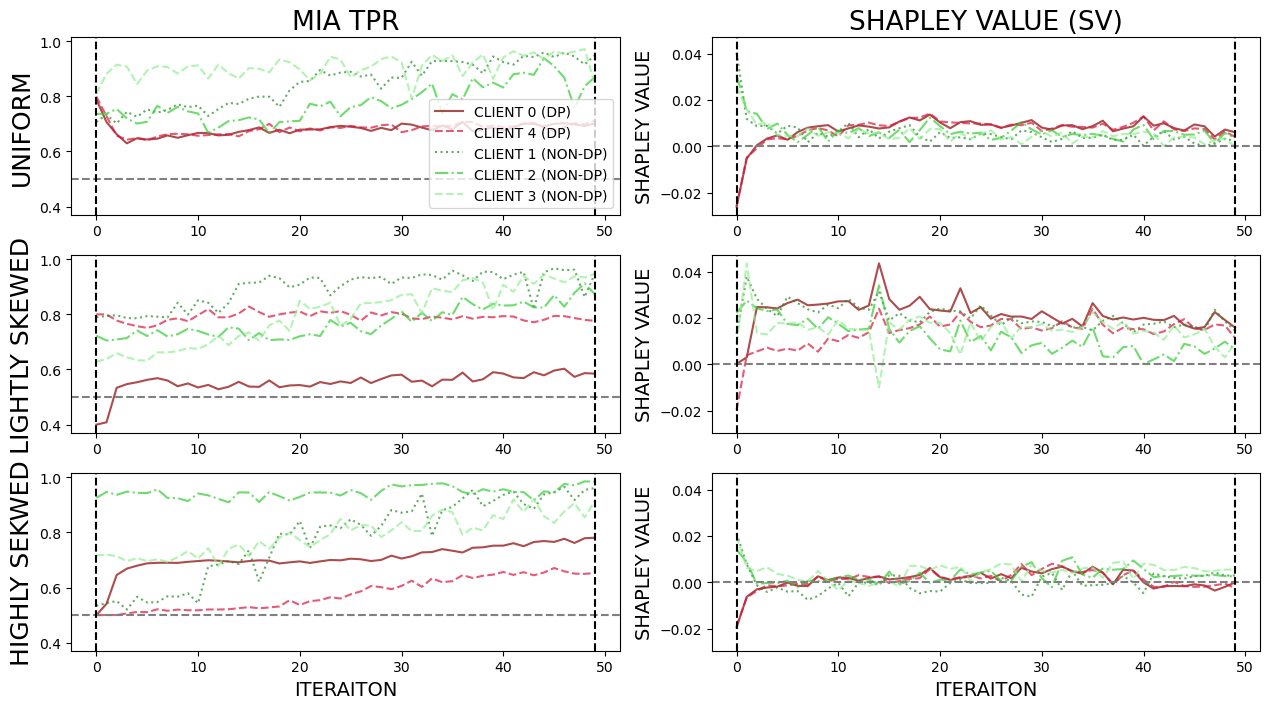

In [19]:
datasets = ['cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['without_DP', 'with_DP']

client_styles = {
    0: ('#8B0000', '-'),   # Dark Red (Solid)
    4: ('#DC143C', '--'),  # Crimson Red (Dashed)
    1: ('#228B22', ':'),   # Forest Green (Dotted)
    2: ('#32CD32', '-.'),  # Lime Green (Dash-Dot)
    3: ('#90EE90', '--')   # Light Green (Densely Dotted)
}

for dataset in datasets:
    for version in versions:
        
        fig, axes = plt.subplots(3, 2, figsize=(12.8, 7.2))
        results_MNIST = load_multiple_contribution_attack_results(
            datasets=[dataset],
            scenarios=scenarios,
            versions=[version]
        )

        for scenario, axs in zip(scenarios, axes):
            for client in [0, 4]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (DP)')
            for client in [1, 2, 3]:
                axs[0].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_TPR'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
                axs[1].plot(results_MNIST[f'{scenario}_{version}_{dataset}'][f'{client}_SHAP_ACC'], color=client_styles[client][0], linestyle=client_styles[client][1], alpha=0.7, label=f'CLIENT {client} (NON-DP)')
    
        axes[0,0].legend()
        axes[0,0].set_title("MIA TPR", fontsize=19)
        axes[0,1].set_title("SHAPLEY VALUE (SV)", fontsize=19)

        axes[0,0].set_ylabel('UNIFORM', fontsize=18)
        axes[1,0].set_ylabel('LIGHTLY SKEWED', fontsize=18)
        axes[2,0].set_ylabel('HIGHLY SEKWED', fontsize=18)

        axes[1][0].sharey(axes[0][0])
        axes[2][0].sharey(axes[0][0])
        axes[1][1].sharey(axes[0][1])
        axes[2][1].sharey(axes[0][1])

        x = 49
        for i in range(3):
            axes[i][0].axhline(y=0.5, color='gray', linestyle='--')
            axes[i][1].axhline(y=0.0, color='gray', linestyle='--')
            axes[i][0].axvline(x=0, color='black', linestyle='--')
            axes[i][0].axvline(x=x, color='black', linestyle='--')
            axes[i][1].axvline(x=0, color='black', linestyle='--')
            axes[i][1].axvline(x=x, color='black', linestyle='--')
        for i in range(2):
            axes[2][i].set_xlabel("ITERAITON", fontsize=14)
        for i in range(3):
            axes[i][1].set_ylabel("SHAPLEY VALUE", fontsize=14)
        
        if version == 'with_DP':
            suptitle = "(SOME CLIENTS WITH DP)"
        else:
            suptitle = "(WITHOUT ANY DP)"
        fig.tight_layout()

## Part 2.2: Visual Cross-Correlation Analysis

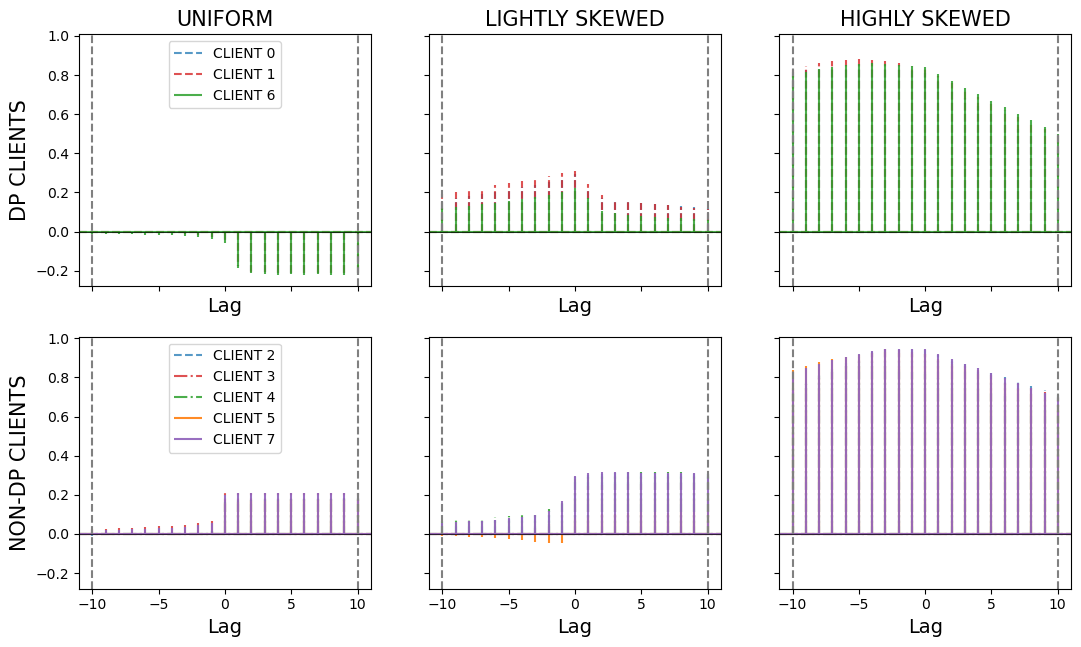

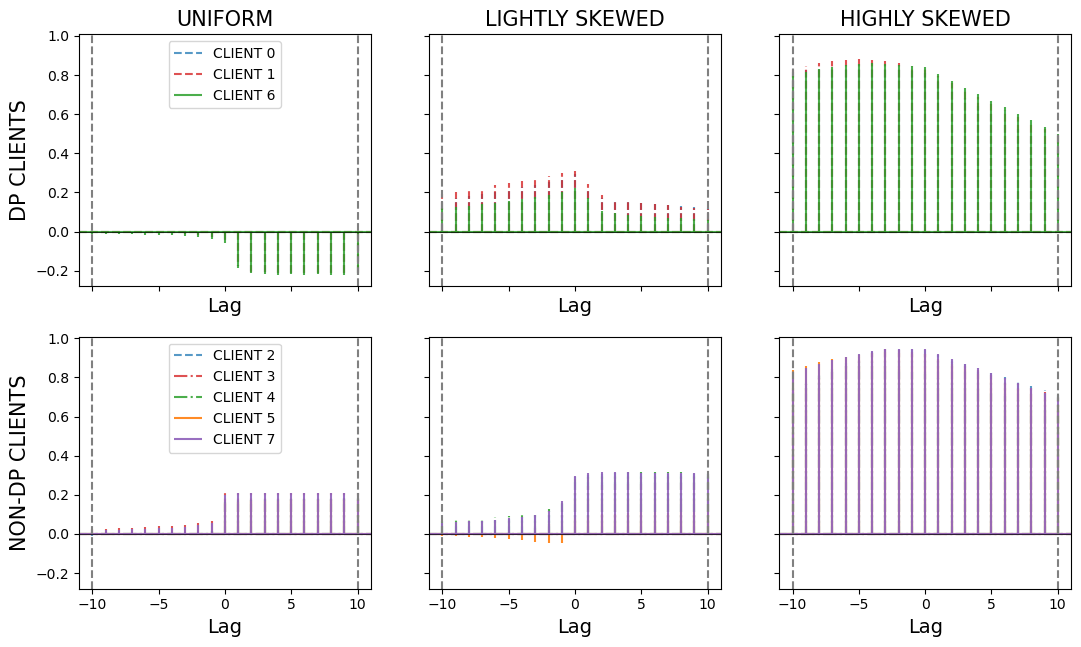

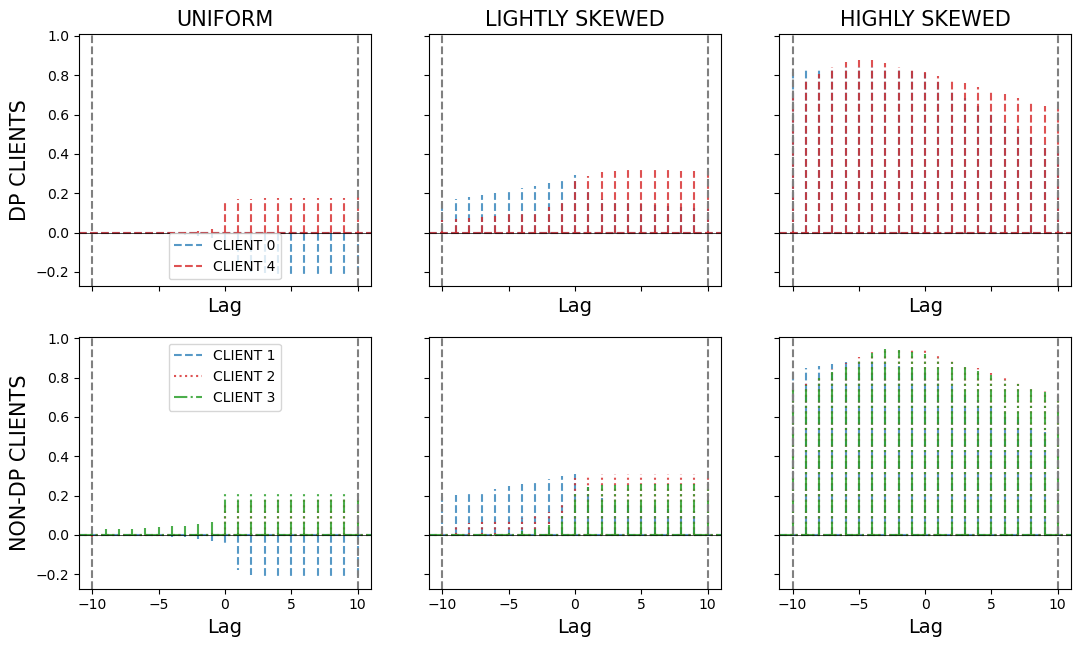

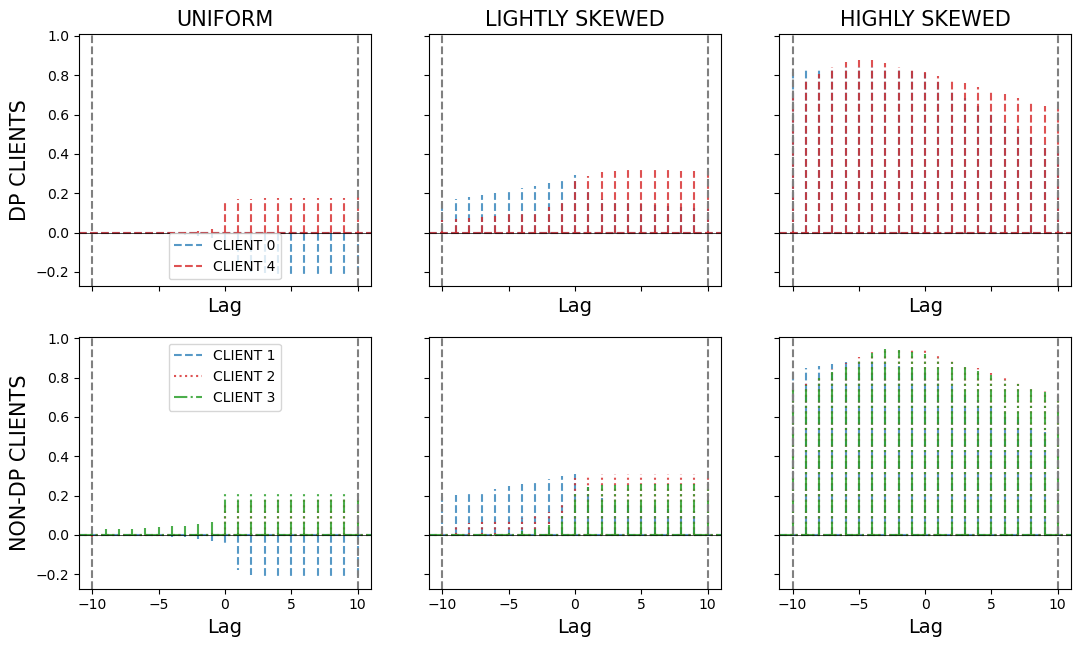

In [20]:
datasets = ['mnist', 'fmnist', 'cifar10-5', 'tissuemnist']
scenarios = ['uniform', 'ls', 'hs']
versions = ['with_DP']

client_styles = {
    0: ('#E6194B', '-'),   # Red (Solid)
    1: ('#FF7F0E', '--'),  # Dark Orange (Dashed)
    2: ('#FFD700', ':'),   # Golden Yellow (Dotted)
    3: ('#FF6347', '-.'),  # Tomato Red (Dash-Dot)
    4: ('#1F77B4', '-'),   # Blue (Solid)
    5: ('#17BECF', '--'),  # Teal (Dashed)
    6: ('#9467BD', ':'),   # Purple (Dotted)
    7: ('#2CA02C', '-.')   # Dark Green (Dash-Dot)
}

with_DP = load_multiple_contribution_attack_results(
    datasets=datasets,
    scenarios=scenarios,
    versions=versions
)

for dataset in datasets:
    fig, axes = plt.subplots(2, 3, figsize=(12.8, 7.2), sharex=True, sharey=True)
    if dataset == 'mnist' or dataset == 'fmnist':
        dp_clients = [0, 1, 6]
        non_dp_clients = [2, 3, 4, 5, 7]
        client_styles = {
            0: ('#1F77B4', '--'),   # Blue (Dashed)
            1: ('#D62728', '--'),   # Red (Dashed)
            2: ('#1F77B4', '--'),   # Blue (Dashed)
            3: ('#D62728', '-.'),   # Red (Dash-Dot)
            4: ('#2CA02C', '-.'),   # Green (Dash-Dot)
            5: ('#FF7F0E', '-'),   # Orange (Solid)
            6: ('#2CA02C', '-'),    # Green (Solid)
            7: ('#9467BD', '-')    # Purple (Solid)
        }
    else:
        dp_clients = [0, 4]
        non_dp_clients = [1, 2, 3]
        client_styles = {
            0: ('#1F77B4', '--'),  # Blue (Dashed)
            1: ('#1F77B4', '--'),  # Blue (Dashed)
            2: ('#D62728', ':'),   # Red (Dot)
            3: ('#2CA02C', '-.'),  # Tomato Red (Dash-Dot)
            4: ('#D62728', '--'),   # Red (Dashed)
        }
    for index, scenario in enumerate(scenarios):
        alpha = 0.75
        for client in dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_ACC"]
            axes[0][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        alpha = 0.75
        for client in non_dp_clients:
            series_A = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_TPR"]
            series_B = with_DP[f"{scenario}_with_DP_{datasets[0]}"][f"{client}_SHAP_ACC"]
            axes[1][index].xcorr(series_A, series_B, maxlags=10, normed=True, color=client_styles[client][0], linestyle=client_styles[client][1], alpha=alpha, label=f'CLIENT {client}')
            alpha += 0.05
        axes[0][index].axvline(x=-10, color='gray', linestyle='--')
        axes[0][index].axvline(x=10, color='gray', linestyle='--')
        axes[1][index].axvline(x=-10, color='gray', linestyle='--')
        axes[1][index].axvline(x=10, color='gray', linestyle='--')
        axes[0][index].axhline(y=0, color='black', linewidth=0.5)
        axes[1][index].axhline(y=0, color='black', linewidth=0.5)
        axes[0][index].set_xlabel("Lag", fontsize = 14)
        axes[1][index].set_xlabel("Lag", fontsize = 14)

    axes[0][0].legend()
    axes[1][0].legend()
    axes[0,0].set_ylabel('DP CLIENTS', fontsize=15)
    axes[1,0].set_ylabel('NON-DP CLIENTS', fontsize=15)
    axes[0,0].set_title("UNIFORM", fontsize=15)
    axes[0,1].set_title("LIGHTLY SKEWED", fontsize=15)
    axes[0,2].set_title("HIGHLY SKEWED", fontsize=15)